# Install library

In [101]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [103]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [104]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [105]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [106]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [107]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [108]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0.0    5000
1.0    5000
3.0    5000
5.0    5000
6.0    5000
7.0    5000
8.0    5000
2.0    2500
4.0    2500
9.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

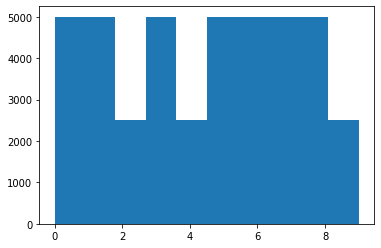

In [109]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

In [110]:
# train test split
# stratify y label
x_train_removed, x_valid_removed, y_train_removed, y_valid_removed = train_test_split(x_train_removed, y_train_removed, 
                                                                      test_size=0.3, random_state=42, stratify=y_train_removed)

In [111]:
print(x_train_removed.shape)
print(y_train_removed.shape)
print(x_valid_removed.shape)
print(y_valid_removed.shape)

(29750, 32, 32, 3)
(29750,)
(12750, 32, 32, 3)
(12750,)


In [112]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0.0    3500
1.0    3500
3.0    3500
5.0    3500
6.0    3500
7.0    3500
8.0    3500
2.0    1750
4.0    1750
9.0    1750
dtype: int64


In [113]:
df = pd.DataFrame(y_valid_removed.flatten())
print(df.value_counts())
del df

0.0    1500
1.0    1500
3.0    1500
5.0    1500
6.0    1500
7.0    1500
8.0    1500
2.0     750
4.0     750
9.0     750
dtype: int64


## Stacked AutoEncoder

#### Load Stacked AE models weight

In [114]:
def create_StackedAE01_model(k_size):
    # AE 01 encode
    input_img = Input(shape=(32, 32, 3))  # 0; 32*32*3
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1; 32*32*64
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3

    # AE 02 encode
    conv2 = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE02_1")(conv1) # 4; 32*32*128
    conv2 = BatchNormalization(name="BN_AE02_1")(conv2) # 5
    conv2 = Activation('relu', name="Relu_AE02_1")(conv2) # 6
    pool1 = MaxPooling2D(name="Pool_AE02_1")(conv2)  # 7; 16*16*128

    # AE 03 encode
    conv3 = Conv2D(256, (k_size, k_size), padding='same', name="Dense_AE03_1")(pool1) # 8; 16*16*256
    conv3 = BatchNormalization(name="BN_AE03_1")(conv3) # 9
    conv3 = Activation('relu', name="Relu_AE03_1")(conv3) # 10
    pool2 = MaxPooling2D(name="Pool_AE03_1")(conv3)  # 11; 8*8*256

    # AE 03 decode
    unpool1 = UpSampling2D(name="Unpool_AE03_1")(pool2)  # 12; 16*16*256
    conv4 = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE03_2")(unpool1) # 13; 16*16*128
    conv4 = BatchNormalization(name="BN_AE03_2")(conv4) # 14
    conv4 = Activation('relu', name="Relu_AE03_2")(conv4) # 15

    # AE 02 decode 
    unpool2 = UpSampling2D(name="Unpool_AE02_1")(conv4)  # 16; 32*32*128
    conv5 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE02_2")(unpool2) # 17; 32*32*64
    conv5 = BatchNormalization(name="BN_AE02_2")(conv5) # 18
    conv5 = Activation('relu', name="Relu_AE02_2")(conv5) # 19

    # AE 01 decode
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv5) # 20; 32*32*3
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 21
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 22

    return Model(input_img, decoded)

In [115]:
class StackedAE01:
    def __init__(self, k_size, optimizer):
        self.optimizer = optimizer
        
        self.encoder = None
        self.autoencoder = create_StackedAE01_model(k_size)
        
    def compile(self, loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)
        
    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
        ae_model_path = '../models/AE/Stacked01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE03_1').output)
        encode_model_path = '../models/AE/Stacked01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae01, ae02, ae03):
        self.autoencoder.layers[1].set_weights(ae01.layers[1].get_weights())
        self.autoencoder.layers[4].set_weights(ae02.layers[1].get_weights())
        self.autoencoder.layers[8].set_weights(ae03.layers[1].get_weights())
        
        self.autoencoder.layers[13].set_weights(ae03.layers[6].get_weights())
        self.autoencoder.layers[17].set_weights(ae02.layers[6].get_weights())
        self.autoencoder.layers[20].set_weights(ae01.layers[4].get_weights())
    
    def load_stack_weights(self, ae_model_path, encoder_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE03_1').output)
        self.encoder.load_weights(encoder_model_path)

In [116]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = StackedAE01(ae_ksize, ae_optimizer)
stack01.load_stack_weights('../models/AE/Stacked01_AE_Best.hdf5', '../models/AE/Stacked01_Encoder_Best.hdf5')

## Train

#### Create Model AE to CNN

In [117]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 8,8,256
    x = Conv2D(512,(3,3),padding = "same",activation= "relu")(output)
    x = Conv2D(512,(3,3),padding = "same",activation= "relu")(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

#### Train without data augumentation

In [93]:
%%time

encoder = stack01.encoder
encoder.trainable = False
model01 = create_StackedAE01_CNN01_model(encoder) # transfer learning

# adam = Adam(lr=0.001, decay=0.005)
adam = Adam() # defalut
model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_001_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model01_history = model01.fit(x_train_removed, y_train_removed_onehot,
                      batch_size=32,
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_removed, y_valid_removed_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
930/930 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.6599
Epoch 00001: val_loss improved from inf to 6.91926, saving model to ../models/CNN\Model_001_Best.hdf5
930/930 [==============================] - 126s 136ms/step - loss: 0.9787 - accuracy: 0.6599 - val_loss: 6.9193 - val_accuracy: 0.1845
Epoch 2/400
930/930 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7197
Epoch 00002: val_loss improved from 6.91926 to 4.26165, saving model to ../models/CNN\Model_001_Best.hdf5
930/930 [==============================] - 125s 134ms/step - loss: 0.8026 - accuracy: 0.7197 - val_loss: 4.2616 - val_accuracy: 0.3197
Epoch 3/400
930/930 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.7414
Epoch 00003: val_loss did not improve from 4.26165
930/930 [==============================] - 125s 134ms/step - loss: 0.7414 - accuracy: 0.7414 - val_loss: 4.9504 - val_accuracy: 0.3233
Epoch 4/400
930/930 [========================

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

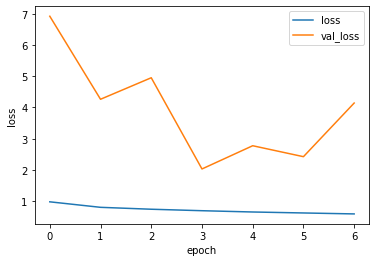

<Figure size 432x288 with 0 Axes>

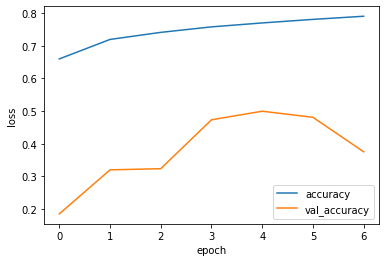

In [94]:
# plot training
mdoel01_hist_df = pd.DataFrame(model01_history.history)

plt.figure()
mdoel01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel01_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [118]:
model01.load_weights('../models/CNN/Model_001_Best.hdf5')
model01.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 11s 36ms/step - loss: 2.0156 - accuracy: 0.4702


[2.0155839920043945, 0.4702000021934509]

In [119]:
y_pred = model01.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.96      0.45      1000
           1       0.97      0.56      0.71      1000
           2       0.27      0.56      0.36      1000
           3       0.61      0.28      0.38      1000
           4       0.79      0.10      0.18      1000
           5       0.74      0.34      0.46      1000
           6       0.54      0.90      0.67      1000
           7       1.00      0.10      0.18      1000
           8       0.98      0.09      0.16      1000
           9       0.72      0.83      0.77      1000

    accuracy                           0.47     10000
   macro avg       0.69      0.47      0.43     10000
weighted avg       0.69      0.47      0.43     10000



#### Train with data augumentation

Epoch 1/400
929/929 [==============================] - ETA: 0s - loss: 1.4363 - accuracy: 0.4955
Epoch 00001: val_loss improved from inf to 3.05249, saving model to ../models/CNN\Model_002_Best.hdf5
929/929 [==============================] - 151s 162ms/step - loss: 1.4363 - accuracy: 0.4955 - val_loss: 3.0525 - val_accuracy: 0.3504
Epoch 2/400
929/929 [==============================] - ETA: 0s - loss: 1.3065 - accuracy: 0.5403
Epoch 00002: val_loss did not improve from 3.05249
929/929 [==============================] - 154s 165ms/step - loss: 1.3065 - accuracy: 0.5403 - val_loss: 3.4524 - val_accuracy: 0.3775
Epoch 3/400
929/929 [==============================] - ETA: 0s - loss: 1.2590 - accuracy: 0.5532
Epoch 00003: val_loss improved from 3.05249 to 2.44478, saving model to ../models/CNN\Model_002_Best.hdf5
929/929 [==============================] - 152s 164ms/step - loss: 1.2590 - accuracy: 0.5532 - val_loss: 2.4448 - val_accuracy: 0.3833
Epoch 4/400
929/929 [========================

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

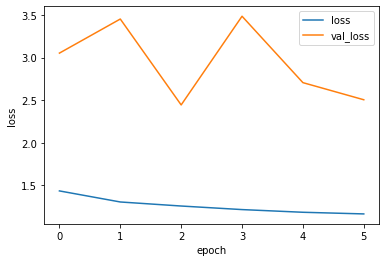

<Figure size 432x288 with 0 Axes>

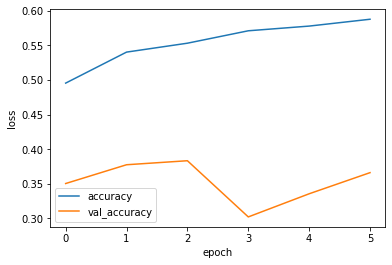

In [91]:
%%time

encoder = stack01.encoder
encoder.trainable = False
model02 = create_StackedAE01_CNN01_model(encoder) # transfer learning

adam = Adam() # defalut
model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_002_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

train_datagen = ImageDataGenerator(
#     rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    channel_shift_range=0.2
    )

batch_size = 32
train_datagenerator = train_datagen.flow(x_train_removed, y_train_removed_onehot, batch_size)
valid_datagenerator = ImageDataGenerator().flow(x_valid_removed, y_valid_removed_onehot, batch_size)

model02_history = model02.fit_generator(train_datagenerator,
                              steps_per_epoch=int(len(x_train_removed)//batch_size),
                              epochs=400,
                              validation_data=valid_datagenerator,
                              validation_steps=int(len(y_valid_removed)//batch_size),
                              verbose=1,
                              shuffle=True,
                              callbacks=[es_cb, cp_cb])

# plot training
mdoel02_hist_df = pd.DataFrame(model02_history.history)

plt.figure()
mdoel02_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel02_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [121]:
model02.load_weights('../models/CNN/Model_002_Best.hdf5')
model02.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 13s 40ms/step - loss: 2.4442 - accuracy: 0.3834


[2.4441587924957275, 0.38339999318122864]

In [122]:
y_pred = model02.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.80      0.38      1000
           1       0.39      0.94      0.55      1000
           2       0.41      0.01      0.01      1000
           3       0.70      0.02      0.04      1000
           4       0.54      0.33      0.41      1000
           5       0.73      0.17      0.28      1000
           6       0.46      0.76      0.57      1000
           7       0.97      0.04      0.07      1000
           8       0.89      0.02      0.03      1000
           9       0.44      0.75      0.55      1000

    accuracy                           0.38     10000
   macro avg       0.58      0.38      0.29     10000
weighted avg       0.58      0.38      0.29     10000

